In [ ]:
# Execute the common model notebook
%run common_model.ipynb

# Create the model with constraints and objective
mdl, produccion_vars, products = create_model()

# Solve the model
solve_model(mdl)


Model: guia5problematipo2
 - number of variables: 3
   - binary=0, integer=0, continuous=3
 - number of constraints: 9
   - linear=9
 - parameters: defaults
 - objective: none
 - problem type is: LP
* Production model solved with objective: 5700
* Total benefit=5700
Production of A: 50.0
Production of B: 80.0
Production of C: 0


In [ ]:
#***Added by JL - 2024 Mar 03th - Checking sensitivity analysis *****')

# Initialize lists to store the results
rhs_values = []
dual_values = []

real_rhs_value = 0

m = 0.01


In [ ]:
# Perform sensitivity analysis of the RHS ### Aux: misma función que VM

def perform_sensitivity_analysis():
    lp = LinearRelaxer.make_relaxed_model(mdl)
    lp.solve()
    cpx = lp.get_engine().get_cplex()

    return cpx.solution.sensitivity.rhs()


In [ ]:
# Adjust RHS and solve ### Aux: misma función que VM

def solve(c, rhs_value):
    print("---")
    print("- Adjusting RHS to: {0}".format(rhs_value))
    c.rhs = rhs_value
    solution = mdl.solve()
    
    if solution is not None:       
        print("* Production model solved with objective: {:g}".format(solution.objective_value))
        print("* Total benefit=%g" % solution.objective_value)
        for p in products:
            print("Production of {product}: {prod_var}".format(product=p[0], prod_var=produccion_vars[p].solution_value))
        return solution
    else:
        print("No solution found for RHS value: {0}".format(rhs_value))
        return None  # Return None to indicate that the model is infeasible at this point
    

In [ ]:
# Report values for the chart

def report_with_min_dem(rhs_value, aux):
    rhs_values.append(rhs_value)
    dual_values.append(-1 * aux.dual_value) #Diferencia con grafico funcional vs disp     ### AUX: PARA DEM MÍN _ ej B
    
def report_without_min_dem(rhs_value, aux):
    rhs_values.append(rhs_value)    
    dual_values.append(-1 * aux.reduced_cost) ## aux, para A y C reduced_cost; para B dual_value   ### AUX: PARA VAR _ ej A y C

In [ ]:
produccion_vars

{('A', 50, 100, 0): docplex.mp.Var(type=C,name='produccion_A_50_100_0'),
 ('B', 40, 120, 80): docplex.mp.Var(type=C,name='produccion_B_40_120_80'),
 ('C',
  30,
  999999999999999,
  0): docplex.mp.Var(type=C,name='produccion_C_30_999999999999999_0')}

In [ ]:
### AUX, PROBANDO

#produccion_vars['produccion_A_50_100_0']
#produccion_vars.values['produccion_A_50_100_0']
#list(produccion_vars.values)
print(list(produccion_vars.values()))
print("--------------------------")
list(produccion_vars.values())[0].reduced_cost
print(list(produccion_vars.values())[2].reduced_cost)
print("Me guardo la variable:")
hola123=list(produccion_vars.values())[2]
hola123.reduced_cost

[docplex.mp.Var(type=C,name='produccion_A_50_100_0'), docplex.mp.Var(type=C,name='produccion_B_40_120_80'), docplex.mp.Var(type=C,name='produccion_C_30_999999999999999_0')]
--------------------------
-20.000000000000007
Me guardo la variable:


-20.000000000000007

In [ ]:
### Aux: misma función que VM, cambia solo parámetros actuales
### aux: pEro, esta función no es monótona: no me sirve la forma actual de ordenar, requiere algo más

# constraint_name: nombre de la restricción sobre cuyo rhs iterar (eje 'x')
# prod_var_or_min_dem_constraint: restricción de demanda mínima del producto, o si la variable del producto (si el mismo no posee dem mín) (para eje 'y').
def iterate_over_rhs(constraint_name, prod_var_or_min_dem_constraint, report_function):
    c = mdl.get_constraint_by_name(constraint_name)
    if c is None:
        print("Constraint with name '{0}' not found.".format(constraint_name))
        return    
            
    # Perform initial sensitivity analysis to get the starting lower and upper bounds
    initial_sensitivity = perform_sensitivity_analysis()
    
    # Find the sensitivity range for the specified constraint
    for c_sens, (lower, upper) in zip(mdl.iter_constraints(), initial_sensitivity):
        if c_sens.name == constraint_name:
            
            # Report the real RHS value for the chart
            global real_rhs_value #use the global keyword to declare that you want the function to update the global variable
            real_rhs_value = c_sens.rhs.constant
            report_function(real_rhs_value, prod_var_or_min_dem_constraint)
        
            # *********Store and report the initial lower and upper bounds for the chart*********
            print("---Initial lower bound: {0}".format(lower))
            rhs = lower
            solution = solve(c, rhs)
            if solution is not None:                
                report_function(rhs, prod_var_or_min_dem_constraint)

            print("---Initial upper bound: {0}".format(upper))
            rhs = upper
            solution = solve(c, rhs)
            if solution is not None:
                report_function(rhs, prod_var_or_min_dem_constraint)
            # ********* End of lower and upper bounds *********
            
            
            #Decrease rhs starting from lower bound - m
            rhs = lower - m
            while True:
                if rhs < 0:
                    break ## Stop if the rhs is lower than 0                
            
                solution = solve(c, rhs)                
                if solution is None:
                    break  # Stop if the model is infeasible
                else:
                    report_function(rhs, prod_var_or_min_dem_constraint) #Diferencia con grafico funcional vs disp
                    
                # Perform sensitivity analysis to get the new lower bound
                new_sensitivity = perform_sensitivity_analysis()                
                for c_new_sens, (new_lower, _) in zip(mdl.iter_constraints(), new_sensitivity):
                    if c_new_sens.name == constraint_name: 
                        rhs = new_lower
                        if rhs < 0:
                            break ## Stop if the rhs is lower than 0                
                            
                        solution = solve(c, rhs)
                        if solution is None:
                            break  # Stop if the model is infeasible
                        report_function(c_new_sens.rhs.constant, prod_var_or_min_dem_constraint)
                        
                        rhs = new_lower - m

                        break


            # Increase rhs starting from upper bound + m
            rhs = upper + m
            
            while True:
                if rhs >= mdl.infinity:
                    break ## Stop if the rhs reaches or exceeds infinity

                solution = solve(c, rhs)
                if solution is None:
                    break  # Stop if the model is infeasible
                else:
                    report_function(rhs, prod_var_or_min_dem_constraint) #Diferencia con grafico funcional vs disp

                # Perform sensitivity analysis to get the new upper bound
                new_sensitivity = perform_sensitivity_analysis()
                for c_new_sens, (_, new_upper) in zip(mdl.iter_constraints(), new_sensitivity):
                    if c_new_sens.name == constraint_name:                        
                        rhs = new_upper
                        if rhs >= mdl.infinity:
                            break ## Stop if the rhs reaches or exceeds infinity

                        solution = solve(c, rhs)
                        if solution is None:
                            break  # Stop if the model is infeasible
                        report_function(c_new_sens.rhs.constant, prod_var_or_min_dem_constraint)
                        
                        rhs = new_upper + m

                        break

In [ ]:
# Usage of the iterate_over_rhs method
constraint_nameX = 'Disp_Equipo3'  # The name of the constraint to analyze
product_name="C" ### AUX: AHORA SOLO HAY QUE CAMBIAR ESTE PRODUCT_NAME Y DES/COMENTAR EN REPORT EL REDUCED_COST O DUAL_VALUE. [EN PROGRESO].

# Buscamos el product_name en el array "products" para consultar en su tercera posición si el mismo tiene demanda mínima
# (aux: products tiene tuplas, esto obtiene la tupla que tiene 'product_name' como primer valor)
idx = next((i for i, prod in enumerate(products) if prod[0] == product_name), None)
if idx is None:
    raise ValueError(f"ERROR: no se encontró el product_name: {product_name} en el array products.")

# Obtenemos la restricción (a la que tomarle el dual_value) si el producto tiene demanda mínima
# o la variable del producto en caso contrario (al que tomarle el reduced_cost), para llamar a iterar
dem_min = products[idx][3] > 0
if dem_min:
    print(f"Demanda mínima encontrada para el producto {product_name}.")
    constraint_nameY = f"DemandMin_{product_name}"
    prod_var_or_min_dem_constraint = mdl.get_constraint_by_name(constraint_nameY)
    report_function = report_with_min_dem
else:
    print(f"Demanda mínima No encontrada para el producto {product_name}.")
    # esto da, por ejemplo prod_var_or_min_dem_constraint=list(produccion_vars.values())[0] ## "A"
    # Aux: es necesario que la key sea una tupla? Sería mucho más simple / legible si la key fuera directamente "A"
    prod_var_or_min_dem_constraint = next((value for key, value in produccion_vars.items() if key[0] == product_name), None)
    print(f"[DEBUG] le paso: {prod_var_or_min_dem_constraint}.")
    if prod_var_or_min_dem_constraint is None:
        raise ValueError(f"ERROR: no se encontró {product_name} en produccion_vars.")
    report_function = report_without_min_dem
iterate_over_rhs(constraint_nameX, prod_var_or_min_dem_constraint, report_function)

### AUX TEMP, SOLO PARA EL PLOT, PRE REFACTOR
prod_y=product_name


Demanda mínima No encontrada para el producto C.
[DEBUG] le paso: produccion_C_30_999999999999999_0.
---Initial lower bound: 80.0
---
- Adjusting RHS to: 80.0
* Production model solved with objective: 3200
* Total benefit=3200
Production of A: 0
Production of B: 80.0
Production of C: 0
---Initial upper bound: 140.0
---
- Adjusting RHS to: 140.0
* Production model solved with objective: 8200
* Total benefit=8200
Production of A: 100.0
Production of B: 80.0
Production of C: 0
---
- Adjusting RHS to: 79.99
No solution found for RHS value: 79.99
---
- Adjusting RHS to: 140.01
* Production model solved with objective: 8200.5
* Total benefit=8200.5
Production of A: 100.0
Production of B: 80.0
Production of C: 0.01666666666665151
---
- Adjusting RHS to: 172.0
* Production model solved with objective: 9800
* Total benefit=9800
Production of A: 100.0
Production of B: 80.0
Production of C: 53.33333333333334
---
- Adjusting RHS to: 172.01
* Production model solved with objective: 9800.3
* Total b

In [ ]:
### Aux: plot generalizable

# Plot the chart: objective vs. rhs value

import matplotlib.pyplot as plt
import matplotlib

# Optional: xunit: unit to plot for x-axis
# Optional: yunit: unit to plot for y-axis
def plot(xunit, yunit):   
    
    # Set default font size for all text elements
    matplotlib.rcParams.update({'font.size': 18})
    
    # Dibujar líneas horizontales entre los puntos
    for i in range(len(rhs_values) - 1):
        plt.hlines(dual_values[i], rhs_values[i], rhs_values[i + 1], linewidth=6, color='C0')
        
    # Dibujar un vector con origen en el último punto y dirección hacia el infinito horizontalmente
    plt.annotate('', xy=(plt.xlim()[1], dual_values[-1]), xytext=(rhs_values[-1], dual_values[-1]),
             arrowprops=dict(arrowstyle="->", lw=2, color='C0'))

    #Print current real value
    plt.axvline(x=real_rhs_value, color='g', linestyle='--', label='Valor actual')

    # Set the x-axis and y-axis ticks to the values we are printing
    plt.xticks(rhs_values)
    plt.yticks(dual_values) 


    plt.xlabel('{0} {1}'.format(constraint_nameX, xunit), labelpad=20, color='#DC143C')
    plt.ylabel('C. Oport \nprod min {}\n{}'.format(yunit, prod_y), rotation=0, labelpad=70, color='#DC143C')
    plt.title('Costo de oportunidad del producto {}'.format(product_name), pad=30)
    plt.grid(True, which='both', linestyle='--', linewidth=0.2, color='gray', alpha=0.7)
    plt.show()
    

In [ ]:
### DEBUG
print("rhs_values", rhs_values)
print("dual_values", dual_values)

rhs_values [110, 80.0, 140.0, 140.01, 172.0, 172.01, 272.0, 272.01]
dual_values [20.000000000000007, 20.000000000000007, 20.000000000000007, 0, 0, 0, 0, 0]


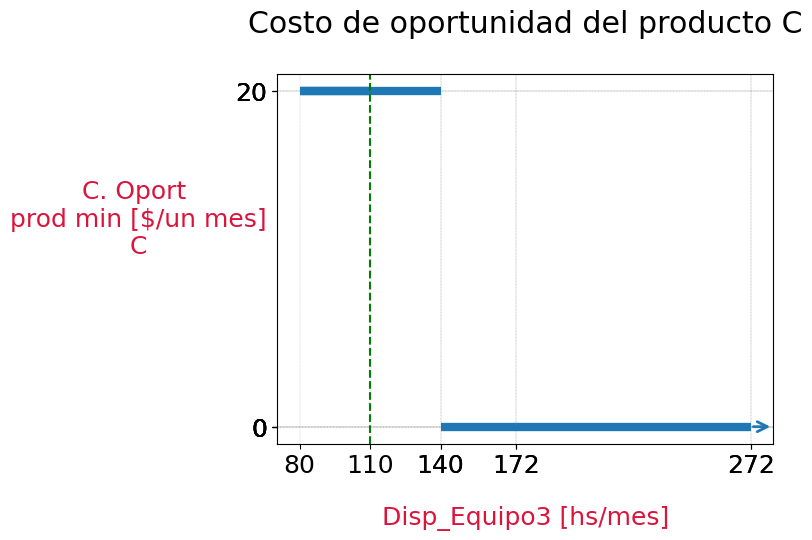

In [ ]:
# Usage of pLot the chart
plot("[hs/mes]", "[$/un mes]")